**машина Больцмана: ассоциативная память**

Евгений Борисов <esborisov@sevsu.ru>

##  загружаем данные 

In [1]:
# !ls data

In [2]:
import pickle
import gzip

with gzip.open('data/17x31.pkl.gz','rb') as f:
    ideal,test = pickle.load(f)

In [3]:
import matplotlib.pyplot as plt

def plot_images(data,figsize=(10,4)):
    fig, ax = plt.subplots(1,len(data), figsize=figsize)
    for i in range(len(data)): 
        ax[i].axis('off')
        ax[i].imshow(data[i]) #,cmap='GnBu')

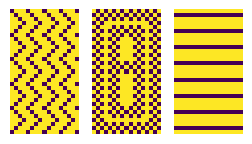

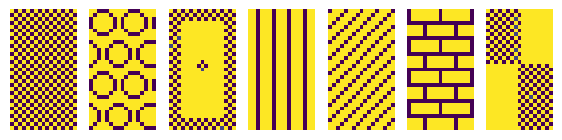

In [4]:
plot_images(ideal,(3,2))
plot_images(test,(7,2))

## формируем датасет

In [5]:
import numpy as np
from numpy import random as rng

In [6]:
(w,h),n = ideal[0].shape,len(ideal)
x_train = np.sign( 127.-np.stack(ideal).reshape(n,w*h) )

(w,h),n = test[0].shape,len(test)
x_test = np.sign( 127.-np.stack(test).reshape(n,w*h) )

display( x_train.shape, x_test.shape )

(3, 527)

(7, 527)

In [7]:
# x_test

# базовая модель

![hopfield](http://mechanoid.su/content/neural-net-hopfield-associative-memory.html/hopfield.bmp)

In [8]:
class HophieldNet:
    
    def __init__(self):
        self._weight = 0.
        self._bias = 0.
        
    def fit(self,x):
        assert len(x)>1
        batch_size, data_size = x.shape
        self._weight = x.T.dot(x)
        self._bias = x.sum(axis=0)
        # обнуляем главную диагональ матрицы весов
        # т.е. удаляем обратную связь нейрона на самого себя 
        self._weight = self._weight *(np.ones([data_size,data_size])-np.eye(data_size,data_size))
        return self
    
    def forward(self,x,max_iter=8):
        o = x
        for _ in range(max_iter):
            o_ = o # сохраняем состояние
            o = self._forward_step(o) # переходим в новое состояние
            # если состояние не изменилось то завершаем
            if np.all(o==o_): break
        return o        
    
    def _forward_step(self,x):
        return np.sign( x.dot(self._weight) - self._bias )
    

# модель

энергия сети

$E = - \left( s\cdot W \right) * s - s*\theta $   

$\cdot$ - матричное умножение  
$*$ - поэлементное умножение   
$s$ - состояние сети   
$W$ - матрица весов   
$\theta$ - вектор сдвигов  

генерируем случайное состояние r

и считаем изменение энергии сети

$\Delta E = E(r) - E(s)$

если $\Delta E_i\leq 0$   
то $s_i:=r_i$  
иначе принимаем $s_i:=r_i$ c вероятностью $p_i$

$$
p(\Delta E,t) = 1-\frac{1}{1+\exp\left(-\frac{\Delta E}{t}\right)}
$$

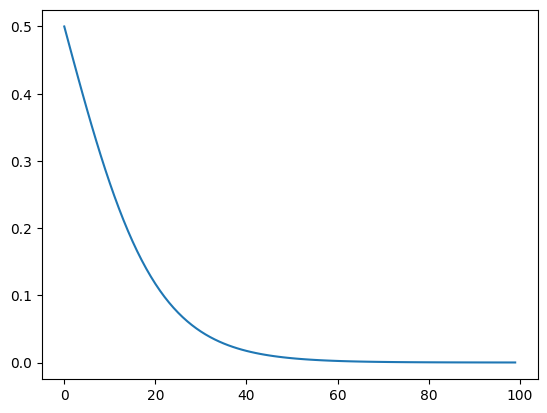

In [9]:
p = lambda dE,t: 1.-1./(1.+np.exp(-dE/t)) 
de,t = np.linspace(0,100,100), 10
plt.plot(p(de,t))

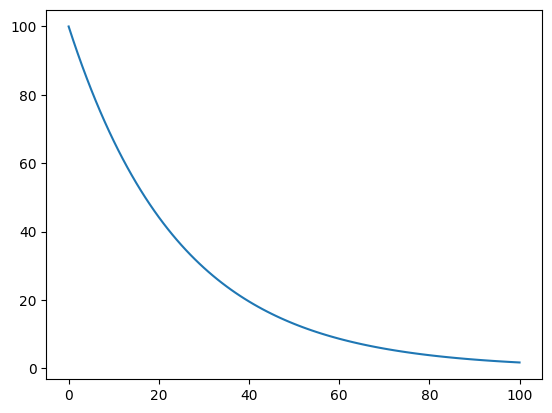

In [10]:
t = [100]
for _ in range(100): t.append( t[-1]*.96  )
plt.plot(range(101),t)

In [11]:
class BoltzmanNet(HophieldNet):

    def __init__(self):
        super().__init__()
        self._t = 100. # "температура" модели 

    def forward(self,x,max_iter=64):
        self._t = 100. # начальная "температура"    
        return super().forward(x,max_iter)
    
    def _forward_step(self,x):
        o = self._change_state(x.copy())
        self._t *= .96 # понизить температуру
        return o
            
    def _change_state(self,state):
        random_state = self._random_state(state.shape) # случайное состояние
        dE = self._energy(random_state) - self._energy(state) # изменение энергии нейронов
        
        # если изменение энергии меньше нуля 
        mask_0 = dE<0 # условие: изменение энергии нейрона
        # то принимаем новое состояние нейрона
        state[mask_0] = random_state[mask_0]

        # если изменение энергии больше нуля 
        # то принимаем новое состояние нейрона с вероятностью p
        p = self._prob(dE)
        mask_1 = rng.rand(*state.shape) < p # нейроны, для которых будем менять состояние
        mask_1 = np.logical_and(np.logical_not(mask_0),mask_1)
        state[mask_1] = random_state[mask_1]
        
        return state
                
    def _random_state(self,shape):
        return rng.randint(0,2,shape)*2-1 # случайное состояние
    
    def _energy(self,x): 
        return -x.dot(self._weight)*x - x*self._bias
    
    def _prob(self,dE):
        return 1.-1./(1.+np.exp(-dE/self._t)) # вероятности переходов в новое состояние
        

In [12]:
from time import time
# инициализация генератора псевдослучайных чисел
rng.seed(seed= int(((time()%1)/(time()//1))*1e11) )

# загружаем память сети

In [13]:
model = BoltzmanNet().fit(x_train)

# тестируем

In [14]:
o = model.forward(x_test)

In [15]:
(w,h),n = test[0].shape,len(test)
o_ = ((1-o.reshape(n,w,h))*127).astype(np.uint8)

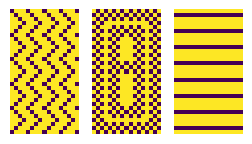

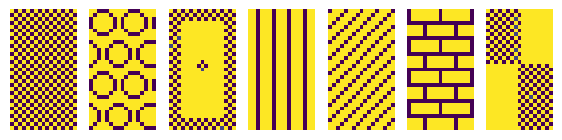

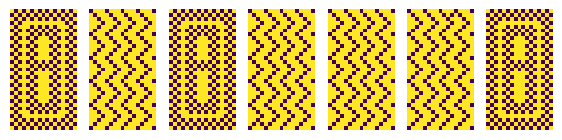

In [16]:
plot_images(ideal,(3,2))
plot_images(test,(7,2))
plot_images(o_,(7,2))